In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import tensorflow as tf
import time
import scipy

import collections, numpy

import data_loader as dl
import data_transformer as dt

from sklearn.cluster import KMeans
from keras.utils import to_categorical

# helper for setting up the bidirectional, multilayer lstm
def bidirectional_lstm(input_data, num_layers, rnn_size, keep_prob, lengths=None):
    output = input_data
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer),reuse=tf.AUTO_REUSE):

            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, input_keep_prob = keep_prob)

            outputs, states = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                              cell_bw, 
                                                              output,
                                                              dtype=tf.float32,
                                                              sequence_length=lengths)
            output = tf.concat(outputs,2)

    return output

In [11]:
# change this path to match the path of where you have the
# training_50 and validation files
txt_data_path = '/home/mikey/Data/ProteinNet/casp7_txt/'

max_len = 500 # max len of the protein taken into account
n_angles = 2 # 3 if consider all angles or 2 if only phi and psi

The data_lim is important because so far the full 13000 proteins crashes my system with 16Gb of ram

Load training data

In [5]:
file_name = 'training_50'
data_lim = 2000
prim_train, evo_train, dih_train, mask_train = (dl.parse_primary_from_file(txt_data_path + file_name, data_lim), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name, data_lim),
                                                dl.load_file('./'+file_name+'_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name, data_lim))
dih_train = dih_train[:data_lim]
len(prim_train), prim_train[0].shape, len(evo_train), evo_train[0].shape, len(dih_train), dih_train[0].shape, len(mask_train), mask_train[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 2000/2000 [00:00<00:00, 68786.15it/s]


Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(2000, (70, 20), 2000, (70, 21), 2000, (70, 3), 2000, (70,))

Load validation data

In [6]:
file_name = 'validation'
prim_valid, evo_valid, dih_valid, mask_valid = (dl.parse_primary_from_file(txt_data_path + file_name), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name),
                                                dl.load_file('./'+ file_name + '_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name))
len(prim_valid), prim_valid[0].shape, len(evo_valid), evo_valid[0].shape, len(dih_valid), dih_valid[0].shape, len(mask_valid), mask_valid[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 224/224 [00:00<00:00, 72617.41it/s]

Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(224, (269, 20), 224, (269, 21), 224, (269, 3), 224, (269,))

Pad the data and limit protein length. Prepare the data for training

In [7]:
prim_, evo_, dih_, mask_ = dt.limit_length_and_pad(prim_train, evo_train, dih_train, mask_train, max_len)
x_train, y_train = np.concatenate([prim_, evo_], axis=2), dih_[:,:,:n_angles]
prim_v, evo_v, dih_v, mask_v = dt.limit_length_and_pad(prim_valid, evo_valid, dih_valid, mask_valid, max_len)
x_valid, y_valid = np.concatenate([prim_v, evo_v], axis=2), dih_v[:,:,:n_angles]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

padded
(1892,) (70, 20)
padded
(1892,) (70, 21)
padded
(1892,) (70, 3)
padded
(1892,) (70, 1)
padded
(213,) (269, 20)
padded
(213,) (269, 21)
padded
(213,) (269, 3)
padded
(213,) (269, 1)


((1892, 500, 41), (1892, 500, 2), (213, 500, 41), (213, 500, 2))

In [27]:
def manual_clusters(n_clusters):
    # these manually selecteed clusters will be chosen from left to right
    # when n_clusters < man_clusters.shape[0]
    man_clusters = np.array([[-1.5, 0, 0], [-1.5, 2.5, 0], [1.5, 0.5, 0], [-2.2, -2.5, 0],
                          [-1.5, 0, np.pi], [-1.5, 0, -np.pi], [-1.5, 2.5, np.pi], [-1.5, 2.5, -np.pi],
                            [0,0,0],[0,0,0]])
    try:
        return {
            i+1: man_clusters[:i+1] for i in range(man_clusters.shape[0])
        }[n_clusters]
    except KeyError as e:
        print("Manual clusters only support max", man_clusters.shape[0])
        print(e)
        raise

def kmeans_clusters(angles, limit_data, filter_, n_clusters):
    """
        angles: [..., ..., 3]
        limit_data: int, how many protein to consider for clustering
        filter_: bool, deciding if clusters too close to each other should be merged
    """
    def dist2(p1, p2):
        return np.sum((p1-p2)**2)

    def fuse(points, min_dist):
        ret = []
        d2 = min_dist * min_dist
        n = len(points)
        taken = [False] * n
        for i in range(n):
            if not taken[i]:
                count = 1
                point = points[i]
                taken[i] = True
                for j in range(i+1, n):
                    if dist2(points[i], points[j]) < d2:
                        point += points[j]
                        count+=1
                        taken[j] = True
                point /= count
                ret.append(point)
        return np.array(ret)
    
    print("Fitting KMeans...")
    km = KMeans(n_clusters=n_clusters, random_state=0, verbose=0, max_iter=1000).fit(angles[:limit_data].reshape(-1,n_angles))
    print("Done")
    if filter_:
        return fuse(km.cluster_centers_, min_dist=np.abs(np.max(angles)) / 10.)
    else:
        return km.cluster_centers_

def get_cluster_centers(select_clusters_n, mode='manual'):
    return {
        'manual': lambda n_clusters: manual_clusters(n_clusters=n_clusters),
        'kmeans': lambda n_clusters: kmeans_clusters(angles=y_train, limit_data=200, filter_=True, n_clusters=n_clusters)
    }[mode](select_clusters_n)

select_clusters_n = 10
# initialize clusters - this might filter ones that are too close
clusters = get_cluster_centers(select_clusters_n = select_clusters_n, mode='kmeans')[:,:n_angles]
n_clusters_after_fuse = clusters.shape[0]

# add missing clusters to much the desired number
clusters = np.pad(clusters, ((0, select_clusters_n - n_clusters_after_fuse), (0,0)), mode='constant')
n_clusters = clusters.shape[0]

"n_clusters_after_fuse:", n_clusters_after_fuse, 'fused', select_clusters_n - n_clusters_after_fuse, 'padded to', clusters.shape

Fitting KMeans...
Done


('n_clusters_after_fuse:', 10, 'fused', 0, 'padded to', (10, 2))

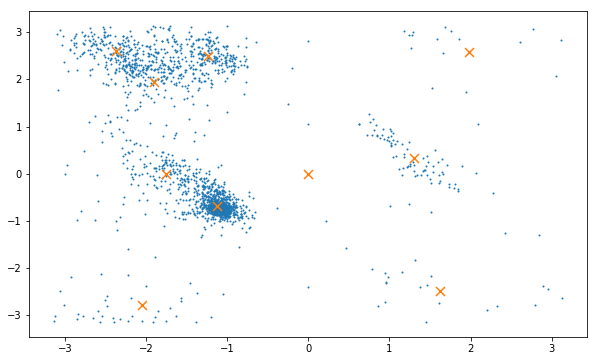

In [28]:
def plot_cluster_centers(data, clusters, x_i, y_i, data_lim=10):
    plt.figure(figsize=(10,6))
    plt.scatter(y_valid[:data_lim][:,:,x_i], y_valid[:data_lim][:,:,y_i], s=1)
    plt.scatter(clusters[:,x_i], clusters[:,y_i], marker='x', s=80)
    
plot_cluster_centers(y_valid, clusters, x_i=0, y_i=1, data_lim=10)
if n_angles == 3:
    plot_cluster_centers(y_valid, clusters, x_i=1, y_i=2, data_lim=10)
    plot_cluster_centers(y_valid, clusters, x_i=0, y_i=2, data_lim=10)

In [29]:
y_train_labels_ = np.argmin(scipy.spatial.distance_matrix(y_train.reshape(-1,n_angles), clusters), 
                            axis=1).reshape(y_train.shape[0], y_train.shape[1])

y_valid_labels_ = np.argmin(scipy.spatial.distance_matrix(y_valid.reshape(-1,n_angles), clusters), 
                            axis=1).reshape(y_valid.shape[0], y_valid.shape[1])

y_train_labels = to_categorical(y_train_labels_, num_classes=n_clusters)
y_valid_labels = to_categorical(y_valid_labels_, num_classes=n_clusters)

y_train_labels.shape, y_valid_labels.shape, np.unique(y_train_labels_), np.unique(y_valid_labels_), n_clusters

((1892, 500, 10),
 (213, 500, 10),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 10)

In [39]:
tf.reset_default_graph()

class ModelHelpers:
    @staticmethod
    @tf.custom_gradient
    def clip_grad_layer(x, eps=1e-10):
        def grad(dy):
            return tf.clip_by_value(dy, eps, eps)
        return tf.identity(x), grad
    
    @staticmethod
    def input_placeholders(max_len, input_columns):
        X = tf.placeholder(tf.float32, [None, max_len, input_columns], name="X")
        input_mask = tf.placeholder(tf.bool, [None, max_len], name="input_mask")
        return X, input_mask

    @staticmethod
    def labels_placeholders(max_len, n_clusters, n_angles):
        y = tf.placeholder(tf.float32, [None, max_len, n_clusters], name='y')
        y_angles = tf.placeholder(tf.float32, [None, max_len, n_angles], name='y_angles')
        return y, y_angles

    @staticmethod
    def clusters(init_clusters, trainable=False, clip_gradient_eps=None):
        clusters_tf = tf.Variable(initial_value=init_clusters, dtype=np.float32, trainable=True)
        clusters_tf = tf.clip_by_value(clusters_tf, -np.pi, np.pi)
        if clip_gradient_eps:
            clusters_tf = ModelHelpers.clip_grad_layer(clusters_tf, eps=clip_gradient_eps)
        return clusters_tf

    @staticmethod
    def conv_layer(in_, neurons, filter_size):
        if type(in_) == list:
            in_ = tf.concat(in_, axis=2)
        return tf.layers.conv1d(in_, neurons, filter_size, activation=tf.nn.relu, padding='same')

    @staticmethod
    def mask_all(tensors_list, mask):
        res = []
        for tensor in tensors_list:
            res.append(tf.boolean_mask(tensor, mask))
        return res
    
helpers = ModelHelpers()

X, input_mask = helpers.input_placeholders(max_len = max_len, input_columns = 41)
y, y_angles = helpers.labels_placeholders(max_len, n_clusters, n_angles)

clusters_tf = helpers.clusters(init_clusters=clusters, trainable=True, clip_gradient_eps=None)

# construct the feature extraction part of the network
conv1a = helpers.conv_layer(X, 32, 5)
conv1b = helpers.conv_layer(conv1a, 32, 5)
conv2a = helpers.conv_layer(conv1b, 64, 5)
conv2b = helpers.conv_layer(conv2a, 64, 5)
conv3 = helpers.conv_layer([conv1b, conv2b], 128, 5) # residual connection is automated in the conv_layer helper
conv3 = tf.layers.dropout(conv3, rate=0.5)

## alternative to the cnn. very slow
# lstm = bidirectional_lstm(X, 1, 32, keep_prob=0.05)

# construct the classification part of the network
dense = tf.layers.dense(conv3, 32, activation='relu')
logits = tf.layers.dense(dense, n_clusters)
logits = tf.layers.dropout(logits, rate=0.05)
y_pred = tf.nn.softmax(logits)

# apply mask to all outputs used for losses (beware that the mask flattens them automatically)
y_masked, logits_masked, y_pred_masked, y_angles_masked = helpers.mask_all([y, logits, y_pred, y_angles], input_mask)
shape_after_mask = tf.shape(y_masked)

# computes the weighted sum of clusters (weighted by the predicted prob. dist.)
rad_pred = tf.einsum('ij,bi->bj', clusters_tf, y_pred_masked)

# crossentropy loss on the classification task
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_masked, logits=logits_masked))

# mae computed for each angle separately
mae_vec = tf.reduce_mean(tf.abs(tf.subtract(rad_pred[:,:], y_angles_masked[:,:])), axis=0)
# mae reduced to 1 number
mae = tf.reduce_mean(tf.abs(tf.subtract(rad_pred[:,:], y_angles_masked[:,:])))

# Define the optimizer operation
learning_rate = tf.placeholder(tf.float32)

# we can choose if we want to optimize mae or loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(mae)

# Variables for prediction and accuracy
prediction = tf.argmax(y_pred_masked, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_masked, 1)), tf.float32))

# Initialize the variables (they are assigned default values)
init = tf.global_variables_initializer()

n_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print("Number of parameters:", n_parameters)

Number of parameters: 108638


In [38]:
batch_size = 32
n_epochs = 500

# Start as session
init_learning_rate = 0.01
with tf.Session() as session:

    # Run the initializer
    session.run(init)

    # Training cycle
    for epoch in range(n_epochs):
        print("Epoch:", epoch)
        train_loss = []
        for b in range(0, x_train.shape[0], batch_size):
            _, loss_value, mae_ = session.run([optimizer, loss, mae_vec], feed_dict={X: x_train[b:b+batch_size],
                                                                      y: y_train_labels[b:b+batch_size],
                                                                      y_angles: y_train[b:b+batch_size],
                                                                      learning_rate: init_learning_rate,
                                                                    input_mask: mask_[b:b+batch_size]})
            train_loss.append(mae_)
        
        (validation_accuracy, mae_, pred_, 
         clusters_, y_pred_masked_, rad_pred_) = session.run([accuracy, mae_vec, prediction, 
                                                              clusters_tf, y_pred_masked, rad_pred], 
                                                              feed_dict={X: x_valid, y: y_valid_labels, 
                                                                         y_angles:y_valid,
                                                                        input_mask: mask_v})
#         print("val. loss = %f, val_acc = %f" % (loss_value, validation_accuracy))    
        print("Train MAE = %f" % (np.mean(train_loss)))
        print("Val. MAE", mae_, np.mean(mae_))
        print(collections.Counter(pred_))
#         print(np.mean(y_pred_masked_, axis=0)) # prob. dist mean over clusters
#         print(np.max(y_pred_masked_, axis=0)) # prob. dist max over clusters
        print(init_learning_rate)
#         print(clusters_)
        
        # Shrinks the learning rate every n epochs
        train_loss = []
        if (epoch + 1) % 10 == 0:
            print("Adjusting learning rate")
            init_learning_rate = init_learning_rate / 1.1
    
    print("Optimization done")

    # Calculate training accuracy
    train_accuracy_value, pred_train, shape_after_mask_ = session.run([accuracy, prediction, shape_after_mask], 
                                                                      feed_dict={X: x_train, y: y_train_labels,
                                                                                y_angles: y_train,
                                                                                input_mask: mask_})
    print("Train accuracy:", train_accuracy_value)
    print("Shape after mask:", shape_after_mask_)
    
    # Calculate test accuracy
    test_accuracy_value, pred_test, shape_after_mask_ = session.run([accuracy, prediction, shape_after_mask], 
                                                                    feed_dict={X: x_valid, y: y_valid_labels,
                                                                              y_angles: y_valid,
                                                                              input_mask: mask_v})
    print("Test accuracy:", test_accuracy_value)
    print("Shape after mask:", shape_after_mask_)

Epoch: 0
Train MAE = 1.175417
Val. MAE [0.8189426 1.4264673] 1.122705
Counter({3: 37634})
0.01
Epoch: 1
Train MAE = 1.065721
Val. MAE [0.6189439 1.4430358] 1.0309899
Counter({3: 37634})
0.01
Epoch: 2
Train MAE = 1.025111
Val. MAE [0.60599035 1.4403248 ] 1.0231576
Counter({3: 37634})
0.01
Epoch: 3
Train MAE = 1.019314
Val. MAE [0.6037801 1.4329795] 1.0183798
Counter({3: 37634})
0.01
Epoch: 4
Train MAE = 1.014681
Val. MAE [0.60232353 1.4259623 ] 1.014143
Counter({3: 37634})
0.01
Epoch: 5
Train MAE = 1.010575
Val. MAE [0.60114634 1.4197109 ] 1.0104287
Counter({3: 37634})
0.01
Epoch: 6
Train MAE = 1.006991
Val. MAE [0.6001851 1.4142739] 1.0072294
Counter({3: 37634})
0.01
Epoch: 7
Train MAE = 1.003914
Val. MAE [0.5994081 1.4095434] 1.0044757
Counter({3: 37633, 6: 1})
0.01
Epoch: 8
Train MAE = 1.001280
Val. MAE [0.59877276 1.4055004 ] 1.0021366
Counter({3: 37599, 6: 35})
0.01
Epoch: 9
Train MAE = 0.999062
Val. MAE [0.5982523 1.4021579] 1.000205
Counter({3: 37024, 6: 610})
0.01
Adjusting lear

Train MAE = 0.805083
Val. MAE [0.5673616 1.0596032] 0.8134824
Counter({3: 27425, 6: 10195, 0: 14})
0.005644739300537772
Epoch: 69
Train MAE = 0.802589
Val. MAE [0.5656361 1.0559999] 0.81081796
Counter({3: 27334, 6: 10271, 0: 29})
0.005644739300537772
Adjusting learning rate
Epoch: 70
Train MAE = 0.800188
Val. MAE [0.56365424 1.0522515 ] 0.8079529
Counter({3: 27112, 6: 10474, 0: 48})
0.005131581182307065
Epoch: 71
Train MAE = 0.798128
Val. MAE [0.56250745 1.0496075 ] 0.80605745
Counter({3: 27081, 6: 10476, 0: 77})
0.005131581182307065
Epoch: 72
Train MAE = 0.796192
Val. MAE [0.5613051 1.0469836] 0.8041444
Counter({3: 27027, 6: 10481, 0: 126})
0.005131581182307065
Epoch: 73
Train MAE = 0.794346
Val. MAE [0.55998814 1.04414   ] 0.80206406
Counter({3: 26877, 6: 10585, 0: 172})
0.005131581182307065
Epoch: 74
Train MAE = 0.792579
Val. MAE [0.5587492 1.0414014] 0.8000753
Counter({3: 26737, 6: 10635, 0: 262})
0.005131581182307065
Epoch: 75
Train MAE = 0.790891
Val. MAE [0.5577145 1.0389521] 0.

Train MAE = 0.749789
Val. MAE [0.5378613  0.97095776] 0.75440955
Counter({3: 22922, 6: 8192, 0: 6520})
0.0031863081771035654
Adjusting learning rate
Epoch: 130
Train MAE = 0.749309
Val. MAE [0.5376174 0.9698795] 0.7537484
Counter({3: 22825, 6: 8209, 0: 6600})
0.0028966437973668773
Epoch: 131
Train MAE = 0.748911
Val. MAE [0.53749573 0.9691925 ] 0.7533441
Counter({3: 22811, 6: 8197, 0: 6626})
0.0028966437973668773
Epoch: 132
Train MAE = 0.748517
Val. MAE [0.53738296 0.96857166] 0.7529773
Counter({3: 22799, 6: 8159, 0: 6676})
0.0028966437973668773
Epoch: 133
Train MAE = 0.748134
Val. MAE [0.53725815 0.9678928 ] 0.7525755
Counter({3: 22782, 6: 8135, 0: 6717})
0.0028966437973668773
Epoch: 134
Train MAE = 0.747748
Val. MAE [0.5370978  0.96706873] 0.7520833
Counter({3: 22738, 6: 8141, 0: 6755})
0.0028966437973668773
Epoch: 135
Train MAE = 0.747359
Val. MAE [0.5369687 0.9664021] 0.7516854
Counter({3: 22712, 6: 8120, 0: 6802})
0.0028966437973668773
Epoch: 136
Train MAE = 0.746978
Val. MAE [0.5

Train MAE = 0.731811
Val. MAE [0.5317512 0.9383997] 0.7350755
Counter({3: 21757, 0: 8318, 6: 7559})
0.0016350799082655782
Epoch: 191
Train MAE = 0.731617
Val. MAE [0.5316881 0.938053 ] 0.73487055
Counter({3: 21744, 0: 8341, 6: 7549})
0.0016350799082655782
Epoch: 192
Train MAE = 0.731428
Val. MAE [0.53163695 0.93774265] 0.73468983
Counter({3: 21743, 0: 8350, 6: 7541})
0.0016350799082655782
Epoch: 193
Train MAE = 0.731240
Val. MAE [0.5315698 0.9373796] 0.73447466
Counter({3: 21729, 0: 8377, 6: 7528})
0.0016350799082655782
Epoch: 194
Train MAE = 0.731053
Val. MAE [0.5315119 0.9370491] 0.73428047
Counter({3: 21721, 0: 8395, 6: 7518})
0.0016350799082655782
Epoch: 195
Train MAE = 0.730865
Val. MAE [0.53145194 0.93671095] 0.73408145
Counter({3: 21713, 0: 8409, 6: 7512})
0.0016350799082655782
Epoch: 196
Train MAE = 0.730678
Val. MAE [0.531394   0.93638474] 0.73388934
Counter({3: 21706, 0: 8428, 6: 7500})
0.0016350799082655782
Epoch: 197
Train MAE = 0.730490
Val. MAE [0.53134364 0.93607104] 0.7

Train MAE = 0.723008
Val. MAE [0.5288356 0.9226461] 0.72574085
Counter({3: 21166, 0: 9028, 6: 7440})
0.0009229599817706405
Epoch: 251
Train MAE = 0.722905
Val. MAE [0.52880216 0.92247045] 0.7256363
Counter({3: 21159, 0: 9041, 6: 7434})
0.0009229599817706405
Epoch: 252
Train MAE = 0.722805
Val. MAE [0.52877283 0.9223009 ] 0.7255368
Counter({3: 21160, 0: 9037, 6: 7437})
0.0009229599817706405
Epoch: 253
Train MAE = 0.722706
Val. MAE [0.52872735 0.9221029 ] 0.7254151
Counter({3: 21141, 0: 9055, 6: 7438})
0.0009229599817706405
Epoch: 254
Train MAE = 0.722605
Val. MAE [0.52870214 0.9219446 ] 0.7253234
Counter({3: 21142, 0: 9068, 6: 7424})
0.0009229599817706405
Epoch: 255
Train MAE = 0.722506
Val. MAE [0.52867466 0.9217812 ] 0.72522795
Counter({3: 21140, 0: 9075, 6: 7419})
0.0009229599817706405
Epoch: 256
Train MAE = 0.722407
Val. MAE [0.5286468  0.92161727] 0.72513205
Counter({3: 21134, 0: 9084, 6: 7416})
0.0009229599817706405
Epoch: 257
Train MAE = 0.722308
Val. MAE [0.52861917 0.92145234] 

KeyboardInterrupt: 

In [22]:
np.min(rad_pred_)

-0.22896507

Organize model modes:
- predict angles through regression (tanh, *pi)
- predict clusters and optimize for crossentropy
- predict clusters and optimize for MAE
- predict clusters as vectors and optimize for MAE

In [46]:
np.mean(np.abs(clusters_[pred_] - y_valid[mask_v])

array([[0.853431  , 0.29503512, 3.1235397 ],
       [0.57627773, 0.61460125, 3.1102312 ],
       [0.13828385, 0.36523938, 2.9928179 ],
       ...,
       [0.1008271 , 3.0192895 , 3.137029  ],
       [0.251745  , 3.2153685 , 3.141288  ],
       [0.19128823, 2.8222716 , 0.48199463]], dtype=float32)

resnet CNN filter_length = 15 (with 5 it didn't change much either)

*Rad angles, 10 not trainable clusters: 0.59

*Rad angles, 10 trainable clusters, no clipping: MAE [0.43384644 0.721744  ] 0.5777952

*Rad angles, 50 trainable clusters, no clipping: 
Train MAE = 0.545068
Val. MAE [0.43777448 0.7208223 ] 0.5792984